In [3]:
import pandas as pd
df_clean = pd.read_parquet("../data/interim/final_clean.parquet")
df_clean.head()


,row_name,clip_start,clip_end,set_num,set_num:_time,set_p1,set_p1:_time,set_p2,set_p2:_time,servicio,...,inicio_gople:_time,inicio_gople:_x,inicio_gople:_y,fin_golpe,fin_golpe:_time,fin_golpe:_x,fin_golpe:_y,asistencia,asistencia:_time,__source_file
0,1º Servicio,5.007,5.712,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
1,1º Servicio,22.228,22.94,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
2,1º Servicio,42.192,42.897,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
3,1º Servicio,62.27,62.972,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
4,1º Servicio,109.583,110.287,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv


In [4]:
df_filtrado = df_clean.loc[
    df_clean["row_name"] == "Punto",    # condición de filas
    ["row_name", "punto_p1", "punto_p2"]  # columnas que quieres ver
]

In [5]:
df_filtrado

,row_name,punto_p1,punto_p2
523,Punto,0,0
524,Punto,15,0
525,Punto,15,15
526,Punto,15,30
527,Punto,30,30
...,...,...,...
646,Punto,15,40
647,Punto,0,0
648,Punto,0,15
649,Punto,0,30


In [6]:
import pandas as pd

def recortar_por_marcador(df, tipo="juego", limite=1):
    """
    Devuelve el subconjunto del DataFrame hasta que se cumpla la condición de marcador,
    ordenando previamente por 'clip_start'.

    Parámetros
    ----------
    df : pd.DataFrame
        Dataset con columnas de marcador (punto_p1, juego_p1, set_p1, etc.).
    tipo : {"juego", "set"}
        Define si recortamos por juegos o por sets.
    limite : int
        Valor máximo de juegos o sets a incluir (ej. 1 -> hasta que alguno llegue a 1 juego).
    """

    df = df.copy()
    tipo = tipo.lower()

    # 🧩 1️⃣ Asegurar orden cronológico por 'clip_start'
    if "clip_start" not in df.columns:
        raise KeyError("El DataFrame no contiene la columna 'clip_start' necesaria para ordenar.")
    df = df.sort_values("clip_start", ascending=True).reset_index(drop=True)

    # 🧩 2️⃣ Seleccionar columnas según el tipo de marcador
    if tipo == "juego":
        col_p1, col_p2 = "juego_p1", "juego_p2"
    elif tipo == "set":
        col_p1, col_p2 = "set_p1", "set_p2"
    else:
        raise ValueError("El parámetro 'tipo' debe ser 'juego' o 'set'")

    # 🧩 3️⃣ Verificar existencia de columnas
    if col_p1 not in df.columns or col_p2 not in df.columns:
        raise KeyError(f"No se encuentran las columnas {col_p1} / {col_p2} en el DataFrame.")

    # 🧩 4️⃣ Convertir a numéricos (por si vienen como texto o con nulos)
    df[col_p1] = pd.to_numeric(df[col_p1], errors="coerce").fillna(0).astype(int)
    df[col_p2] = pd.to_numeric(df[col_p2], errors="coerce").fillna(0).astype(int)

    # 🧩 5️⃣ Calcular condición de corte
    condicion = (df[col_p1] >= limite) | (df[col_p2] >= limite)

    # 🧩 6️⃣ Localizar la primera fila donde se cumple
    if condicion.any():
        idx_fin = condicion.idxmax()  # primer índice donde True
        subset = df.loc[:idx_fin].reset_index(drop=True)
    else:
        subset = df.copy()

    return subset
df_recortado = recortar_por_marcador(df_clean, tipo="juego", limite=1)

In [7]:
df_recortado

,row_name,clip_start,clip_end,set_num,set_num:_time,set_p1,set_p1:_time,set_p2,set_p2:_time,servicio,...,inicio_gople:_time,inicio_gople:_x,inicio_gople:_y,fin_golpe,fin_golpe:_time,fin_golpe:_x,fin_golpe:_y,asistencia,asistencia:_time,__source_file
0,Servicio Martín Di Nenno,4.007,10.082,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
1,1º Servicio,5.007,5.712,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
2,Set,5.007,2285.428,1º,5.007,0,5.007,0,5.007,1º Servicio Martín Di Nenno,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
3,Juego,5.007,296.263,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
4,Punto,5.007,10.082,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,Punto,293.573,296.263,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
115,1º Servicio,293.573,294.304,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
116,Derecha,294.913,295.627,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,295.4,39,10,Fin golpe,295.4,77,101,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
117,Servicio Federico Chingotto,350.533,366.278,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Federico Chingotto,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv


##Intento para clasificación de golpes en un intervalo de tiempo concreto

In [8]:
df = df_recortado

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def top_golpes_por_jugador_detallado(
    df,
    jugador_col="jugador",
    golpe_col="golpe_q",
    error_col="error",
    top_n=5,
    min_eventos_jugador=1,
    devolver_tabla=True,
    pintar=True
):
    d = df.copy()

    # --- Normalización ---
    for c in [jugador_col, golpe_col, error_col]:
        if c in d.columns:
            d[c] = d[c].astype("string").str.strip().str.lower()
    d = d[d[golpe_col].notna()]

    # --- Clasificar evento ---
    d["categoria"] = "bola dentro"
    d.loc[d[error_col].str.contains("error no forzado", na=False), "categoria"] = "error no forzado"
    d.loc[d[error_col].str.contains("missed", na=False), "categoria"] = "missed"

    # --- Conteo jugador × golpe × categoría ---
    conteo = (
        d.groupby([jugador_col, golpe_col, "categoria"])
         .size()
         .reset_index(name="conteo")
    )

    # Pivot para que cada categoría sea una columna
    tabla = conteo.pivot(index=[jugador_col, golpe_col], columns="categoria", values="conteo").fillna(0)
    tabla["total"] = tabla.sum(axis=1)
    tabla = tabla.reset_index()

    # --- Filtrar top-N por jugador ---
    topn = (
        tabla.sort_values(["jugador", "total"], ascending=[True, False])
             .groupby(jugador_col)
             .head(top_n)
             .reset_index(drop=True)
    )

    # --- Calcular % por golpe ---
    for col in ["bola dentro", "error no forzado", "missed"]:
        if col in topn.columns:
            topn[f"{col}_%"] = (topn[col] / topn["total"] * 100).round(1)

    # --- Calcular % global de acierto (bola dentro) por jugador ---
    aciertos_globales = (
        tabla.groupby(jugador_col)["bola dentro"].sum() / tabla.groupby(jugador_col)["total"].sum() * 100
    ).round(1)

    # --- Pintar ---
    if pintar:
        for jug, g in topn.groupby(jugador_col):
            g = g.sort_values("total", ascending=True)

            # gráfico stacked
            plt.figure(figsize=(8, 4))
            plt.barh(g[golpe_col], g["bola dentro"], color="#4caf50", label="Bola dentro")
            plt.barh(g[golpe_col], g["error no forzado"], left=g["bola dentro"], color="#ff9800", label="Error no forzado")
            plt.barh(g[golpe_col], g["missed"], left=g["bola dentro"] + g["error no forzado"], color="#f44336", label="Missed")

            # Etiquetas de totales
            for i, total in enumerate(g["total"]):
                plt.text(total + 0.3, i, f"{int(total)}", va="center", fontsize=9)

            plt.title(f"Top {top_n} golpes — {jug} (Acierto: {aciertos_globales[jug]}%)")
            plt.xlabel("Número de golpes")
            plt.ylabel("Tipo de golpe")
            plt.legend(title="Categoría", loc="lower right")
            plt.tight_layout()
            plt.show()

    if devolver_tabla:
        return topn.sort_values(["jugador", "total"], ascending=[True, False])


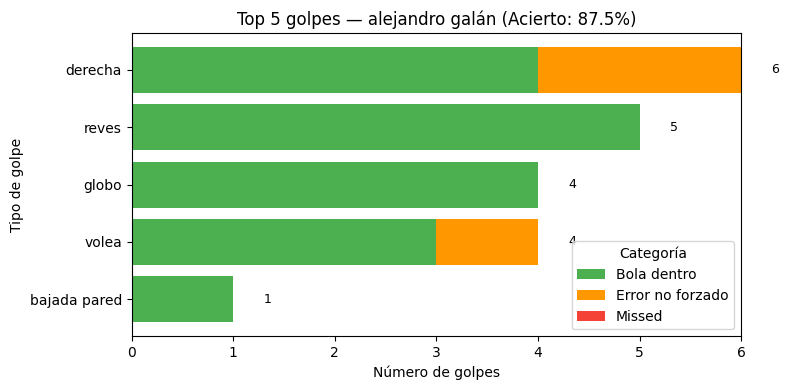

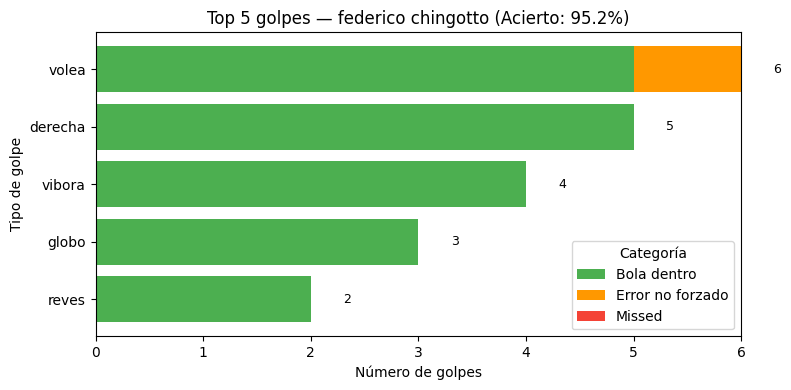

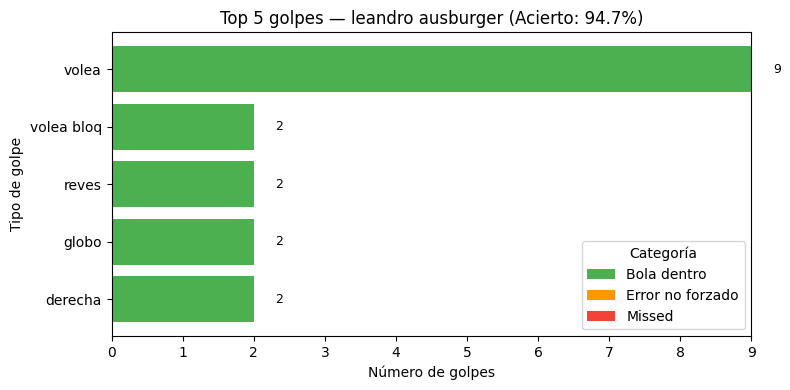

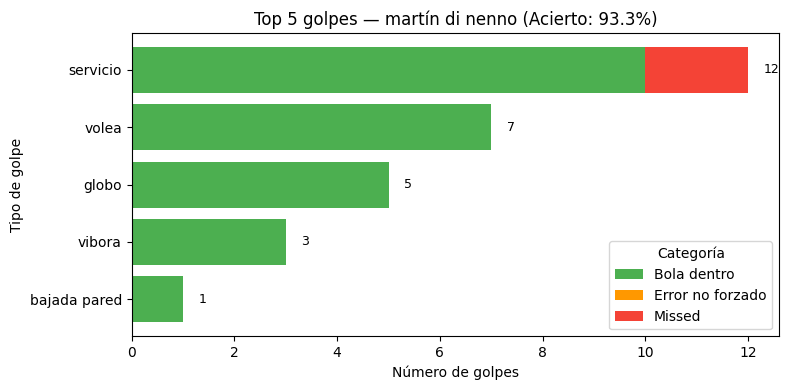

categoria,jugador,golpe_q,bola dentro,error no forzado,missed,total,bola dentro_%,error no forzado_%,missed_%
0,alejandro galán,derecha,4.0,2.0,0.0,6.0,66.7,33.3,0.0
1,alejandro galán,reves,5.0,0.0,0.0,5.0,100.0,0.0,0.0
2,alejandro galán,globo,4.0,0.0,0.0,4.0,100.0,0.0,0.0
3,alejandro galán,volea,3.0,1.0,0.0,4.0,75.0,25.0,0.0
4,alejandro galán,bajada pared,1.0,0.0,0.0,1.0,100.0,0.0,0.0
5,federico chingotto,volea,5.0,1.0,0.0,6.0,83.3,16.7,0.0
6,federico chingotto,derecha,5.0,0.0,0.0,5.0,100.0,0.0,0.0
7,federico chingotto,vibora,4.0,0.0,0.0,4.0,100.0,0.0,0.0
8,federico chingotto,globo,3.0,0.0,0.0,3.0,100.0,0.0,0.0
9,federico chingotto,reves,2.0,0.0,0.0,2.0,100.0,0.0,0.0


In [11]:
top5_tabla = top_golpes_por_jugador_detallado(df, jugador_col="jugador", golpe_col="golpe_q", error_col="error", top_n=5)
display(top5_tabla)


⚠️ No hay datos válidos para Martín Di Nenno. Revisa coordenadas.


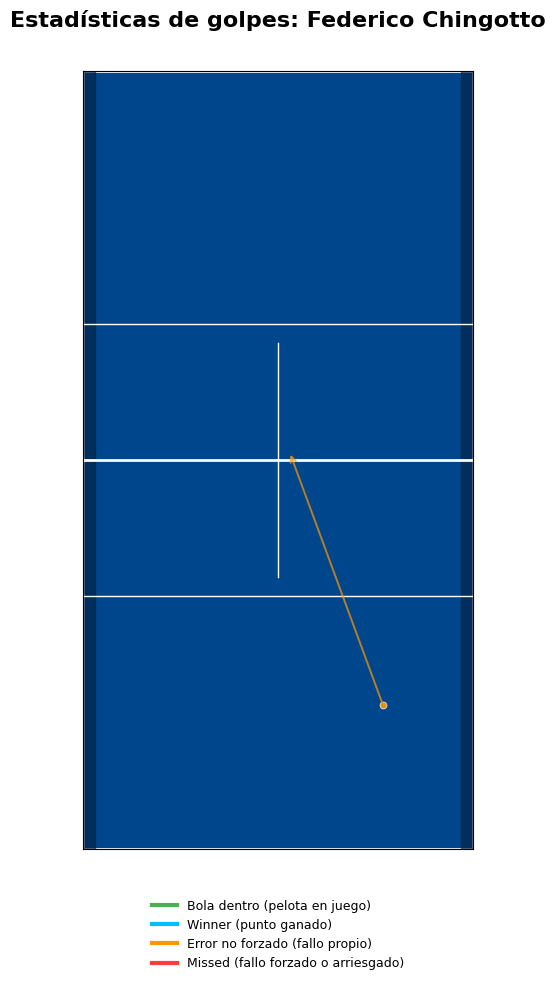

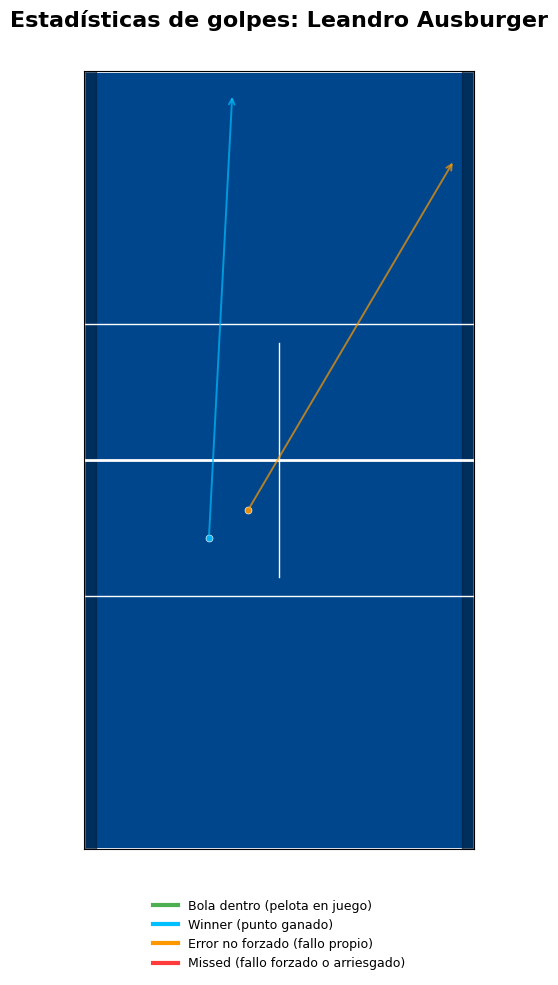

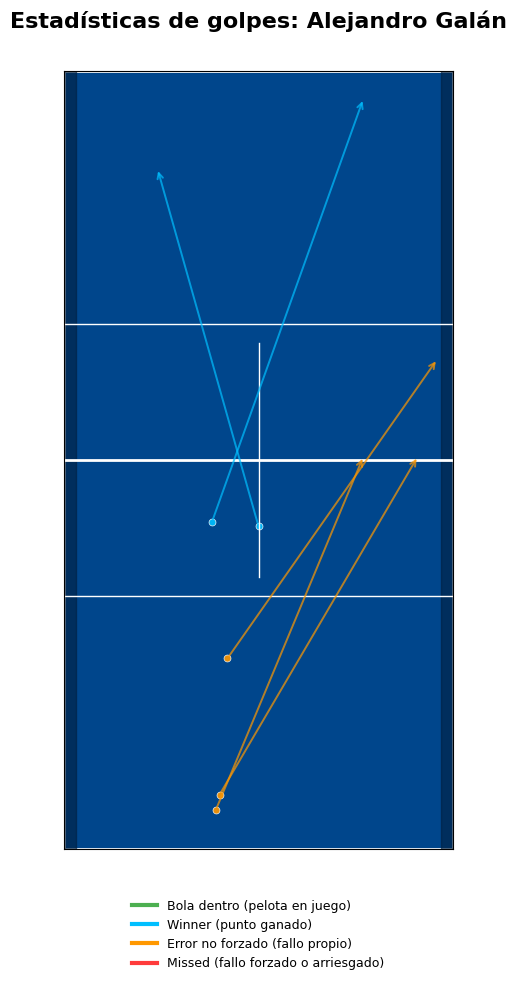

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ======================================================
# CONFIGURACIÓN
# ======================================================

ANCHO_PISTA = 100
LARGO_PISTA = 200

COL_JUGADOR  = "jugador"
COL_WINNER   = "winner"
COL_ERROR    = "error"
COL_INICIO_X = "inicio_gople:_x"
COL_INICIO_Y = "inicio_gople:_y"
COL_FIN_X    = "fin_golpe:_x"
COL_FIN_Y    = "fin_golpe:_y"

COLORES_EVENTO = {
    "winner": "#00BFFF",           # Azul brillante
    "error no forzado": "#FF9800", # Naranja
    "missed": "#FF3B3B",           # Rojo
    "bola dentro": "#4CAF50"       # Verde
}


# ======================================================
# CLASIFICAR EVENTOS
# ======================================================

def clasificar_eventos(df: pd.DataFrame) -> pd.DataFrame:
    df[COL_WINNER] = df[COL_WINNER].astype(str).str.lower().str.strip()
    df[COL_ERROR]  = df[COL_ERROR].astype(str).str.lower().str.strip()

    df["categoria"] = "bola dentro"
    df.loc[df[COL_ERROR].str.contains("error no forzado", na=False), "categoria"] = "error no forzado"
    df.loc[df[COL_ERROR].str.contains("missed", na=False), "categoria"] = "missed"
    df.loc[df[COL_WINNER].str.contains("winner", na=False), "categoria"] = "winner"

    return df


# ======================================================
# DIBUJAR LA PISTA
# ======================================================

def dibujar_pista(ax):
    """Dibuja una pista azul profesional sin texto ni líneas discontinuas."""
    ax.set_xlim(0, ANCHO_PISTA)
    ax.set_ylim(0, LARGO_PISTA)
    ax.set_aspect("equal")
    ax.set_facecolor("#003C77")

    # Fondo con gradiente leve
    for alpha in np.linspace(0.02, 0.15, 8):
        circ = patches.Circle((50, 100), radius=100 + alpha*400,
                              color="#0055A4", alpha=alpha)
        ax.add_patch(circ)

    # Contorno y líneas sólidas
    ax.add_patch(patches.Rectangle((0, 0), 100, 200, linewidth=2,
                                   edgecolor="white", facecolor="none"))

    ax.axhline(y=100, color="white", linewidth=2)   # red
    ax.axhline(y=65, color="white", linewidth=1)    # línea servicio propia
    ax.axhline(y=135, color="white", linewidth=1)   # línea servicio rival
    ax.axvline(x=50, ymin=0.35, ymax=0.65, color="white", linewidth=1)

    # Paredes laterales
    ax.add_patch(patches.Rectangle((0, 0), 3, 200, color="#001F3F", alpha=0.6))
    ax.add_patch(patches.Rectangle((97, 0), 3, 200, color="#001F3F", alpha=0.6))

    # Config ejes
    ax.set_xticks([]); ax.set_yticks([])
    ax.tick_params(colors="white")
    # 🔹 NO invertimos el eje Y: tu campo abajo, rival arriba
    # (En matplotlib el 0 está abajo por defecto)


# ======================================================
# FUNCIÓN PRINCIPAL DE PINTADO
# ======================================================

def pintar_golpes_por_jugador(df: pd.DataFrame):
    jugadores = df[COL_JUGADOR].dropna().unique()

    for jugador in jugadores:
        dfj = df[df[COL_JUGADOR] == jugador].dropna(
            subset=[COL_INICIO_X, COL_INICIO_Y, COL_FIN_X, COL_FIN_Y]
        )

        if dfj.empty:
            print(f"⚠️ No hay datos válidos para {jugador}. Revisa coordenadas.")
            continue

        fig, ax = plt.subplots(figsize=(6, 10))
        dibujar_pista(ax)

        # 🔹 Título principal
        fig.suptitle(f"Estadísticas de golpes: {jugador.title()}",
                     color="black", fontsize=16, fontweight="bold")

        # 🔹 Dibujar golpes (inicio → fin con flecha)
        for _, row in dfj.iterrows():
            cat = row["categoria"]
            color = COLORES_EVENTO.get(cat, "gray")

            # Flecha de dirección del golpe
            ax.annotate("",
                xy=(row[COL_FIN_X], row[COL_FIN_Y]),
                xytext=(row[COL_INICIO_X], row[COL_INICIO_Y]),
                arrowprops=dict(arrowstyle="->", color=color,
                                lw=1.4, alpha=0.7)
            )

            # Punto de inicio
            ax.scatter(row[COL_INICIO_X], row[COL_INICIO_Y],
                       color=color, s=25, edgecolor="white",
                       linewidth=0.5, alpha=0.9)

        # 🔹 Leyenda (texto negro y explicativo)
        handles = [
            plt.Line2D([0], [0], color=c, lw=3, label=lbl)
            for lbl, c in COLORES_EVENTO.items()
        ]
        labels = [
            "Bola dentro (pelota en juego)",
            "Winner (punto ganado)",
            "Error no forzado (fallo propio)",
            "Missed (fallo forzado o arriesgado)"
        ]
        # Reordenar manualmente para la explicación
        handles_ordered = [handles[3], handles[0], handles[1], handles[2]]

        ax.legend(handles=handles_ordered, labels=labels,
                  loc="upper center", bbox_to_anchor=(0.5, -0.05),
                  ncol=1, frameon=False, fontsize=9, labelcolor="black")

        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()


# ======================================================
# EJECUCIÓN
# ======================================================

df = clasificar_eventos(df)
pintar_golpes_por_jugador(df)


In [13]:
import pandas as pd
import numpy as np

def resumen_metricas_por_jugador(
    df,
    jugador_col="jugador",
    cat_col="categoria",
    x_ini="inicio_gople:_x",
    y_ini="inicio_gople:_y",
    x_fin="fin_golpe:_x",
    y_fin="fin_golpe:_y"
):
    # --- Asegurar categorías válidas ---
    cats = ["winner", "error no forzado", "missed", "bola dentro"]
    d = df.copy()

    # --- Conteos de categorías (TODOS los golpes, aunque no tengan coordenadas) ---
    conteos = (
        d.groupby([jugador_col, cat_col])
         .size()
         .unstack(fill_value=0)
         .reindex(columns=cats, fill_value=0)
    )
    conteos["total_golpes"] = conteos.sum(axis=1)

    # % por categoría
    porcentajes = conteos.div(conteos["total_golpes"], axis=0).mul(100).round(1)
    porcentajes = porcentajes.add_suffix("_%")

    # --- Tasa finalizadora (% de golpes que terminan el punto) ---
    finalizan = conteos[["winner", "error no forzado", "missed"]].sum(axis=1)
    tasa_finalizadora = (finalizan / conteos["total_golpes"] * 100).round(1)
    tasa_finalizadora.name = "tasa_finalizadora_%"

    # --- Agresividad y posición (solo si hay coordenadas válidas) ---
    d_coords = d.dropna(subset=[x_ini, y_ini, x_fin, y_fin]).copy()
    if len(d_coords) > 0:
        d_coords["fin_en_rival"] = (d_coords[y_fin] >= 100).astype(int)
        d_coords["fin_ultimo_tercio_rival"] = (d_coords[y_fin] >= 170).astype(int)
        agresividad = (
            d_coords.groupby(jugador_col)[["fin_en_rival", "fin_ultimo_tercio_rival"]]
            .mean().mul(100).round(1)
            .rename(columns={
                "fin_en_rival": "destino_campo_rival_%",
                "fin_ultimo_tercio_rival": "destino_ultimo_tercio_rival_%"
            })
        )
        pos_media = d_coords.groupby(jugador_col)[y_ini].mean().round(1).rename("inicio_y_medio")
    else:
        agresividad = pd.DataFrame(columns=["destino_campo_rival_%","destino_ultimo_tercio_rival_%"])
        pos_media = pd.Series(dtype=float, name="inicio_y_medio")

    # --- Zonas de inicio (solo si hay coordenadas válidas) ---
    if len(d_coords) > 0:
        d_coords["zona_inicio"] = pd.cut(
            d_coords[y_ini],
            bins=[-1, 50, 80, 100],
            labels=["fondo", "media", "red"]
        )
        zonas = pd.crosstab(d_coords[jugador_col], d_coords["zona_inicio"], normalize="index").mul(100).round(1)
        zonas = zonas.reindex(columns=["fondo", "media", "red"], fill_value=0).rename(columns={
            "fondo": "zona_fondo_%", "media": "zona_media_%", "red": "zona_red_%"
        })
    else:
        zonas = pd.DataFrame(columns=["zona_fondo_%","zona_media_%","zona_red_%"])

    # --- Longitud media de golpe (solo si hay coordenadas) ---
    if len(d_coords) > 0:
        d_coords["dist"] = np.hypot(d_coords[x_fin]-d_coords[x_ini], d_coords[y_fin]-d_coords[y_ini])
        long_media = d_coords.groupby(jugador_col)["dist"].mean().round(1).rename("trayectoria_media")
    else:
        long_media = pd.Series(dtype=float, name="trayectoria_media")

    # --- Unir todo ---
    resumen = pd.concat([
        conteos, porcentajes, tasa_finalizadora,
        agresividad, zonas, pos_media, long_media
    ], axis=1).reset_index()

    resumen = resumen.fillna(0)
    return resumen


# --- Ejemplo de uso ---
tabla_resumen = resumen_metricas_por_jugador(df)
print(tabla_resumen)


              jugador  winner  error no forzado  missed  bola dentro  \
0     Alejandro Galán       2                 3       0           19   
1  Federico Chingotto       2                 1       0           20   
2   Leandro Ausburger       1                 1       0           17   
3     Martín Di Nenno       6                 4       2           41   

   total_golpes  winner_%  error no forzado_%  missed_%  bola dentro_%  \
0            24       8.3                12.5       0.0           79.2   
1            23       8.7                 4.3       0.0           87.0   
2            19       5.3                 5.3       0.0           89.5   
3            53      11.3                 7.5       3.8           77.4   

   total_golpes_%  tasa_finalizadora_%  destino_campo_rival_%  \
0           100.0                 20.8                  100.0   
1           100.0                 13.0                  100.0   
2           100.0                 10.5                  100.0   
3       

In [ ]:
import os
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ======================================================
# CONFIGURACIÓN
# ======================================================

ANCHO_PISTA = 100
LARGO_PISTA = 200

COL_JUGADOR  = "jugador"
COL_WINNER   = "winner"
COL_ERROR    = "error"
COL_INICIO_X = "inicio_gople:_x"
COL_INICIO_Y = "inicio_gople:_y"
COL_FIN_X    = "fin_golpe:_x"
COL_FIN_Y    = "fin_golpe:_y"

COLORES_EVENTO = {
    "winner": "#00BFFF",           # Azul brillante
    "error no forzado": "#FF9800", # Naranja
    "missed": "#FF3B3B",           # Rojo
    "bola dentro": "#4CAF50"       # Verde
}


# ======================================================
# FUNCIONES AUXILIARES
# ======================================================

def safe_int(val):
    try:
        if pd.isna(val):
            return 0
        return int(val)
    except Exception:
        return 0


def cargar_datos(ruta=None):
    """Carga el parquet desde la ruta indicada o usa la predeterminada."""
    if ruta is None or ruta.strip() == "":
        ruta = os.path.join(os.path.dirname(__file__), "..", "data", "interim", "final_clean.parquet")
        ruta = os.path.abspath(ruta)
    print(f"📂 Cargando datos desde: {ruta}")
    df = pd.read_parquet(ruta)
    print(f"✅ Datos cargados: {len(df):,} filas.")
    return df


# ======================================================
# RECORTE POR JUEGOS Y MARCADOR
# ======================================================

def recortar_por_marcador(df, limite_juegos):
    """Recorta el dataset hasta que la suma de juegos p1+p2 == limite_juegos."""
    df = df.sort_values("clip_start").reset_index(drop=True)

    if not {"juego_p1", "juego_p2"}.issubset(df.columns):
        raise KeyError("Faltan columnas de marcador 'juego_p1' y 'juego_p2'.")

    df["juego_p1"] = pd.to_numeric(df["juego_p1"], errors="coerce").fillna(0).astype(int)
    df["juego_p2"] = pd.to_numeric(df["juego_p2"], errors="coerce").fillna(0).astype(int)
    df["set_p1"] = pd.to_numeric(df.get("set_p1", 0), errors="coerce").fillna(0).astype(int)
    df["set_p2"] = pd.to_numeric(df.get("set_p2", 0), errors="coerce").fillna(0).astype(int)

    idx_fin = None
    for i, row in df.iterrows():
        if (row["juego_p1"] + row["juego_p2"]) >= limite_juegos:
            idx_fin = i
            break
    if idx_fin is None:
        idx_fin = len(df) - 1

    subset = df.loc[:idx_fin].reset_index(drop=True)
    return subset


def calcular_marcador_y_sets(df):
    """Calcula los sets según reglas oficiales de pádel."""
    set_p1 = set_p2 = 0
    juego_p1 = juego_p2 = 0
    sets_resultados = []

    for _, row in df.iterrows():
        j1, j2 = int(row["juego_p1"]), int(row["juego_p2"])
        s1, s2 = int(row.get("set_p1", 0)), int(row.get("set_p2", 0))

        # Detectar si se cerró set (diferencia ≥ 2 y alguno ≥ 6)
        if (j1 >= 6 or j2 >= 6) and abs(j1 - j2) >= 2:
            ganador = "p1" if j1 > j2 else "p2"
            if ganador == "p1":
                set_p1 += 1
            else:
                set_p2 += 1
            sets_resultados.append((j1, j2))
            juego_p1 = juego_p2 = 0

    # Último marcador parcial
    ult = df.iloc[-1]
    marcador = {
        "set_p1": set_p1,
        "set_p2": set_p2,
        "juego_p1": safe_int(ult["juego_p1"]),
        "juego_p2": safe_int(ult["juego_p2"])
    }

    return marcador, sets_resultados


# ======================================================
# CLASIFICAR EVENTOS
# ======================================================

def clasificar_eventos(df):
    d = df.copy()
    for c in [COL_WINNER, COL_ERROR]:
        if c not in d.columns:
            d[c] = ""
        d[c] = d[c].astype(str).str.lower().str.strip()

    d["categoria"] = "bola dentro"
    d.loc[d[COL_ERROR].str.contains("error no forzado", na=False), "categoria"] = "error no forzado"
    d.loc[d[COL_ERROR].str.contains("missed", na=False), "categoria"] = "missed"
    d.loc[d[COL_WINNER].str.contains("winner", na=False), "categoria"] = "winner"
    return d


# ======================================================
# MÉTRICAS POR JUGADOR
# ======================================================

def resumen_metricas_por_jugador(df, jugador_col="jugador", cat_col="categoria"):
    conteos = df.groupby([jugador_col, cat_col]).size().unstack(fill_value=0)
    conteos["total"] = conteos.sum(axis=1)
    porcentajes = conteos.div(conteos["total"], axis=0).mul(100).round(1)
    resumen = pd.concat([conteos, porcentajes.add_suffix("_%")], axis=1).reset_index()
    return resumen


# ======================================================
# CONSTRUCCIÓN DE CARPETAS DE SALIDA
# ======================================================

def build_output_dir(base_dir, n_juegos, marcador, set_results, df):
    os.makedirs(base_dir, exist_ok=True)

    dataset_name = "desconocido"
    if not df.empty:
        val = str(df.iloc[0, -1]).strip()
        if val and val.lower() not in ("nan", "none", "<na>"):
            dataset_name = os.path.splitext(val)[0]

    sets_text = ",".join([f"{a}-{b}" for a, b in set_results]) if set_results else ""
    j1 = safe_int(marcador.get("juego_p1", 0))
    j2 = safe_int(marcador.get("juego_p2", 0))
    if j1 > 0 or j2 > 0:
        sets_text = f"{sets_text},{j1}-{j2}" if sets_text else f"{j1}-{j2}"
    folder_name = sets_text if sets_text else f"sin_sets__{n_juegos}_juegos"

    output_path = os.path.join(base_dir, dataset_name, folder_name)
    os.makedirs(output_path, exist_ok=True)
    return output_path


# ======================================================
# VISUALIZACIÓN INTERACTIVA CON HEATMAP
# ======================================================

def pintar_pista_interactiva(df: pd.DataFrame, output_dir="outputs/html_pistas"):
    os.makedirs(output_dir, exist_ok=True)
    jugadores = df[COL_JUGADOR].dropna().unique()

    for jugador in jugadores:
        sub = df[df[COL_JUGADOR] == jugador].dropna(
            subset=[COL_INICIO_X, COL_INICIO_Y, COL_FIN_X, COL_FIN_Y]
        )
        if sub.empty:
            print(f"⚠️ No hay datos válidos para {jugador}.")
            continue

        fig = go.Figure()

        # Fondo de pista
        fig.add_shape(type="rect", x0=0, y0=0, x1=ANCHO_PISTA, y1=LARGO_PISTA,
                      line=dict(color="white", width=2))
        fig.add_shape(type="line", x0=0, y0=100, x1=ANCHO_PISTA, y1=100,
                      line=dict(color="white", width=3))
        fig.add_shape(type="line", x0=0, y0=65, x1=ANCHO_PISTA, y1=65,
                      line=dict(color="white", width=1))
        fig.add_shape(type="line", x0=0, y0=135, x1=ANCHO_PISTA, y1=135,
                      line=dict(color="white", width=1))
        fig.add_shape(type="line", x0=50, y0=65, x1=50, y1=135,
                      line=dict(color="white", width=1))

        # Heatmap (zonas de inicio)
        heat = sub[[COL_INICIO_X, COL_INICIO_Y]].dropna()
        if not heat.empty:
            fig.add_trace(go.Histogram2dContour(
                x=heat[COL_INICIO_X],
                y=heat[COL_INICIO_Y],
                colorscale="YlOrRd",
                reversescale=True,
                showscale=False,
                contours=dict(showlines=False),
                opacity=0.3,
                name="Densidad de golpeo"
            ))

        # Trayectorias por categoría
        for cat, color in COLORES_EVENTO.items():
            df_cat = sub[sub["categoria"] == cat]
            if df_cat.empty:
                continue

            for _, r in df_cat.iterrows():
                fig.add_trace(go.Scatter(
                    x=[r[COL_INICIO_X], r[COL_FIN_X]],
                    y=[r[COL_INICIO_Y], r[COL_FIN_Y]],
                    mode="lines+markers",
                    line=dict(color=color, width=2),
                    marker=dict(size=5, color=color),
                    name=cat,
                    legendgroup=cat,
                    showlegend=True,
                    hovertemplate=(
                        f"<b>{cat.title()}</b><br>"
                        f"Inicio: ({r[COL_INICIO_X]:.1f}, {r[COL_INICIO_Y]:.1f})<br>"
                        f"Fin: ({r[COL_FIN_X]:.1f}, {r[COL_FIN_Y]:.1f})<extra></extra>"
                    )
                ))

        fig.update_layout(
            title=f"Pista interactiva — {jugador}",
            plot_bgcolor="#003C77",
            paper_bgcolor="#00244D",
            xaxis=dict(visible=False, range=[0, ANCHO_PISTA]),
            yaxis=dict(visible=False, range=[0, LARGO_PISTA], scaleanchor="x", scaleratio=1),
            legend=dict(
                title="Evento",
                itemsizing="constant",
                bgcolor="rgba(255,255,255,0.2)",
                bordercolor="rgba(255,255,255,0.3)",
                borderwidth=1
            ),
            font=dict(color="white")
        )

        out_path = os.path.join(output_dir, f"pista_{jugador}.html")
        fig.write_html(out_path)
        print(f"💾 Guardada versión interactiva: {out_path}")


# ======================================================
# PIPELINE PRINCIPAL
# ======================================================

def analizar_partido_interactivo():
    ruta = input("📂 Ruta del archivo parquet (Enter para usar la predeterminada): ").strip()
    df0 = cargar_datos(ruta)
    n_juegos = int(input("🎮 ¿Cuántos juegos quieres analizar?: ").strip())

    df_recortado = recortar_por_marcador(df0, n_juegos)
    marcador, sets = calcular_marcador_y_sets(df_recortado)
    print(f"🎯 Marcador parcial — Juegos: {marcador['juego_p1']}-{marcador['juego_p2']} | Sets: {marcador['set_p1']}-{marcador['set_p2']}")

    base = os.path.join("outputs", "figures")
    out_dir = build_output_dir(base, n_juegos, marcador, sets, df0)
    fig_dir = out_dir
    print(f"📁 Resultados guardados en: {os.path.abspath(out_dir)}")

    print("\n📊 Calculando métricas resumen...")
    df_recortado = clasificar_eventos(df_recortado)
    resumen = resumen_metricas_por_jugador(df_recortado)
    resumen.to_csv(os.path.join(out_dir, "resumen_metricas.csv"), index=False)
    print(f"✅ Resumen guardado en {out_dir}")

    print("\n🎾 Generando pistas interactivas...")
    pintar_pista_interactiva(df_recortado, output_dir=fig_dir)

    print("\n✅ Análisis completo.")
    return df_recortado, resumen, marcador, out_dir


# ======================================================
# EJECUCIÓN DIRECTA
# ======================================================

if __name__ == "__main__":
    analizar_partido_interactivo()
